This file is only used for ELEC5306 Project2 Bonus (Group 4)

The analysis and explanation are in Bonus Report.pdf

# 1. Package Loading

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# ################################################
# import packages

import argparse
import math
import random
import shutil
import sys

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader
from torchvision import transforms


from pathlib import Path

from PIL import Image
from torch.utils.data import Dataset


In [ ]:
print(torch.cuda.is_available()) # check if cuda is avaliable so that we could use GPU

True


In [ ]:
# ################################################
# define our Dataset class

class ImageFolder(Dataset):
    """Load an image folder database. Training and testing image samples
    are respectively stored in separate directories:

    .. code-block::

        - rootdir/
            - train/
                - img000.png
                - img001.png
                ...
            - valid/
                - img000.png
                - img001.png
                ...

    Args:
        root (string): root directory of the dataset
        transform (callable, optional): a function or transform that takes in a
            PIL image and returns a transformed version
        split (string): split mode ('train' or 'val')
    """

    def __init__(self, root, transform=None, split="train"):
        splitdir = Path(root) / split

        if not splitdir.is_dir():
            raise RuntimeError(f'Invalid directory "{root}"')

        self.samples = [f for f in splitdir.iterdir() if f.is_file()]

        self.transform = transform

    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            img: `PIL.Image.Image` or transformed `PIL.Image.Image`.
        """
        img = Image.open(self.samples[index]).convert("RGB")
        if self.transform:
            return self.transform(img)
        return img

    def __len__(self):
        return len(self.samples)


# 2. Functions needed

In [ ]:
class Loss(nn.Module):

    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()

    def forward(self, output, target):
        out = {}
        out["mse_loss"] = self.mse(output["x_hat"], target)
        out["loss"] = out["mse_loss"] * 255

        return out

In [ ]:
class AverageMeter:
    """Compute running average."""

    def __init__(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
def configure_optimizers(net, learning_rate):

    optimizer = optim.Adam(
        net.parameters(),
        lr=learning_rate,
    )

    return optimizer

In [ ]:
def save_checkpoint(state, is_best, filename="checkpoint.pth.tar"):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, "checkpoint_best_loss.pth.tar")

In [ ]:
def train_one_epoch(
    model, criterion, train_dataloader, optimizer, epoch, clip_max_norm
):
    model.train()
    device = next(model.parameters()).device

    for i, d in enumerate(train_dataloader):
        d = d.to(device)

        optimizer.zero_grad()

        out_net = model(d)

        out_criterion = criterion(out_net, d)
        out_criterion["loss"].backward()
        if clip_max_norm > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_max_norm)
        optimizer.step()

        if i % 10 == 0:
            print(
                f"Train epoch {epoch}: ["
                f"{i*len(d)}/{len(train_dataloader.dataset)}"
                f" ({100. * i / len(train_dataloader):.0f}%)]"
                f'\tLoss: {out_criterion["loss"].item():.3f} |'
                f'\tMSE loss: {out_criterion["mse_loss"].item():.3f}'
            )


In [ ]:
def test_epoch(epoch, test_dataloader, model, criterion):
    model.eval()
    device = next(model.parameters()).device

    loss = AverageMeter()
    mse_loss = AverageMeter()
    psnr = AverageMeter()
    myssim = AverageMeter()

    with torch.no_grad():
        for d in test_dataloader:
            d = d.to(device)
            out_net = model(d)
            d_out = out_net['x_hat']
            out_criterion = criterion(out_net, d)

            loss.update(out_criterion["loss"])
            mse_loss.update(out_criterion["mse_loss"])
            
            psnr.update(PSNR(d_out, d))
            ssim_val = ssim(d * 255, d_out * 255, data_range=255, size_average=True)
            # print(ssim_val)
            myssim.update(ssim_val)
            

    print(
        f"Test epoch {epoch}: Average losses:"
        f"\tLoss: {loss.avg:.3f} |"
        f"\tMSE loss: {mse_loss.avg:.3f} |"
        f"\tPSNR value: {psnr.avg:.3f} |"
        f"\tSSIM value: {myssim.avg:.3f}\n"
    )

    return loss.avg

# do the test on valid split

In [ ]:
def PSNR(img1, img2):
    # img1 and img2 within range [0, 1]
    img1, img2 = img1.detach(), img2.detach()
    img1 = img1 * 255
    img2 = img2 * 255
    batch_size = img1.shape[0]
    img1 = img1.reshape(batch_size, -1)
    img2 = img2.reshape(batch_size, -1)
    mse = torch.mean((img1 - img2) ** 2)
    return torch.mean(20 * torch.log10(255.0 / torch.sqrt(mse)))


In [ ]:
!pip install pytorch-msssim

In [ ]:
import torch
from pytorch_msssim import ssim

# X: (N,3,H,W) a batch of non-negative RGB images (0~1)
# Y: (N,3,H,W)  

X = torch.randn((2, 3, 10, 10))
Y = torch.randn((2, 3, 10, 10))

X = X * 255
Y = Y * 255

# calculate ssim & ms-ssim for each image
ssim_val = ssim(X, Y, data_range=255, size_average=False) # return (N,)
print(ssim_val)
print(type(ssim_val))


tensor([0.0444, 0.0281])
<class 'torch.Tensor'>


/usr/local/lib/python3.7/dist-packages/pytorch_msssim/ssim.py:51: UserWarning: Skipping Gaussian Smoothing at dimension 2+0 for input: torch.Size([2, 3, 10, 10]) and win size: 11
  f"Skipping Gaussian Smoothing at dimension 2+{i} for input: {input.shape} and win size: {win.shape[-1]}"
/usr/local/lib/python3.7/dist-packages/pytorch_msssim/ssim.py:51: UserWarning: Skipping Gaussian Smoothing at dimension 2+1 for input: torch.Size([2, 3, 10, 10]) and win size: 11
  f"Skipping Gaussian Smoothing at dimension 2+{i} for input: {input.shape} and win size: {win.shape[-1]}"


# 3. Parameters chosen

(N,M) = (128, 192), and use 10 epochs

In [ ]:
seed = 123                                        # for reproducibility
cuda = True                                       # use GPU
save = True                                       # save trained model
dataset = '/content/drive/MyDrive/ELEC5306-2022'  # path to the root of the dataset
checkpoint = ''                                   # load pretrained model
epochs = 10                                      # total training epochs
num_workers = 3                          # multi-process for loading training data
clip_max_norm = 1.0                               # avoid gradient explosion
patch_size = (256, 256)                           # input size for the training network
learning_rate = 1e-4  
batch_size = 16
test_batch_size = 16 
N = 128
M = 192

# 4. New network set-up

Set up the Quantization layer (Binary-Tanh)

In [ ]:
from sklearn.preprocessing import binarize
class BinaryTanh(nn.Module):
    def __init__(self):
        super(BinaryTanh, self).__init__()
        self.hardtanh = nn.Hardtanh()

    def forward(self, input):
        output = self.hardtanh(input)
        threshold = torch.tensor([0]).cuda()
        results = (output>threshold).float()*1
        # output = binarize(output)
        return results

In [ ]:
# threshold = torch.tensor([0.5])

Set up new network

In [ ]:
# ###################################################
# a baseline model

def conv(in_channels, out_channels, kernel_size=5, stride=2):
    return nn.Conv2d(
        in_channels,
        out_channels,
        kernel_size=kernel_size,
        stride=stride,
        padding=kernel_size // 2,
    )


def deconv(in_channels, out_channels, kernel_size=5, stride=2):
    return nn.ConvTranspose2d(
        in_channels,
        out_channels,
        kernel_size=kernel_size,
        stride=stride,
        output_padding=stride - 1,
        padding=kernel_size // 2,
    )


class Network(nn.Module):

    def __init__(self, N, M, init_weights=True, **kwargs):
        super().__init__(**kwargs)

        self.g_a = nn.Sequential(
            conv(3, N),
            conv(N, N),
            conv(N, N),
            conv(N, M),
        )

        self.g_q = nn.Sequential(
             BinaryTanh(),
            
        )

        self.g_s = nn.Sequential(
            deconv(M, N),
            deconv(N, N),
            deconv(N, N),
            deconv(N, 3),
        )

        self.N = N
        self.M = M

        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        y = self.g_a(x)
        quan = self.g_q(y)
        x_hat = self.g_s(quan)
        return {
            "x_hat": x_hat,
            # "x_quan": quan,
        }


    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def compress(self, x):
        y = self.g_a(x)
        return y

    def decompress(self, y_hat):
        x_hat = self.g_s(y_hat).clamp_(0, 1) # Limiting. Limit the value of input to [min, max], output as a tensor
        return {"x_hat": x_hat}

    def quantize(self, x):
      y = self.g_a(x)
      quan = self.g_q(y)
      return quan


# 5. New network training

In [ ]:
torch.manual_seed(seed)
random.seed(seed)

train_transforms = transforms.Compose(
    [transforms.RandomCrop(patch_size), transforms.ToTensor()]
)

test_transforms = transforms.Compose(
    [transforms.CenterCrop(patch_size), transforms.ToTensor()]
)

train_dataset = ImageFolder(dataset, split="train", transform=train_transforms)
test_dataset = ImageFolder(dataset, split="valid", transform=test_transforms)

device = "cuda" if cuda and torch.cuda.is_available() else "cpu"

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=True,
    pin_memory=(device == "cuda"),
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    num_workers=num_workers,
    shuffle=False,
    pin_memory=(device == "cuda"),
)



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
net = Network(N, M)
net = net.to(device)

optimizer = configure_optimizers(net, learning_rate)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min")
criterion = Loss()

last_epoch = 0
if checkpoint:  # load from previous checkpoint
    print("Loading", checkpoint)
    checkpoint = torch.load(checkpoint, map_location=device)
    last_epoch = checkpoint["epoch"] + 1
    net.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    lr_scheduler.load_state_dict(checkpoint["lr_scheduler"])

best_loss = float("inf")
for epoch in range(last_epoch, epochs):
    print(f"Learning rate: {optimizer.param_groups[0]['lr']}")
    train_one_epoch(
        net,
        criterion,
        train_dataloader,
        optimizer,
        epoch,
        clip_max_norm,
    )
    loss = test_epoch(epoch, test_dataloader, net, criterion)
    lr_scheduler.step(loss)

    is_best = loss < best_loss
    best_loss = min(loss, best_loss)

    if save:
        save_checkpoint(
            {
                "epoch": epoch,
                "state_dict": net.state_dict(),
                "loss": loss,
                "optimizer": optimizer.state_dict(),
                "lr_scheduler": lr_scheduler.state_dict(),
            },
            is_best,
        )

Learning rate: 0.0001


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train epoch 0: [0/250 (0%)]	Loss: 547.539 |	MSE loss: 2.147
Train epoch 0: [160/250 (62%)]	Loss: 107.472 |	MSE loss: 0.421
Test epoch 0: Average losses:	Loss: 87.432 |	MSE loss: 0.343 |	PSNR value: 4.664 |	SSIM value: 0.004

Learning rate: 0.0001
Train epoch 1: [0/250 (0%)]	Loss: 82.066 |	MSE loss: 0.322
Train epoch 1: [160/250 (62%)]	Loss: 55.192 |	MSE loss: 0.216
Test epoch 1: Average losses:	Loss: 60.025 |	MSE loss: 0.235 |	PSNR value: 6.303 |	SSIM value: 0.007

Learning rate: 0.0001
Train epoch 2: [0/250 (0%)]	Loss: 65.904 |	MSE loss: 0.258
Train epoch 2: [160/250 (62%)]	Loss: 47.335 |	MSE loss: 0.186
Test epoch 2: Average losses:	Loss: 53.530 |	MSE loss: 0.210 |	PSNR value: 6.799 |	SSIM value: 0.009

Learning rate: 0.0001
Train epoch 3: [0/250 (0%)]	Loss: 49.347 |	MSE loss: 0.194
Train epoch 3: [160/250 (62%)]	Loss: 49.858 |	MSE loss: 0.196
Test epoch 3: Average losses:	Loss: 38.857 |	MSE loss: 0.152 |	PSNR value: 8.190 |	SSIM value: 0.014

Learning rate: 0.0001
Train epoch 4: [0/

# 6. Quantization result

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'compressed-decoded')

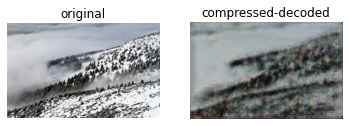

In [ ]:
# visualization
import matplotlib.pyplot as plt

dataset = '/content/drive/MyDrive/ELEC5306-2022'
test_dataset = ImageFolder(dataset, split="valid", transform=transforms.ToTensor())
image = test_dataset[1].unsqueeze(0).to(device)
net.load_state_dict(torch.load('checkpoint_best_loss.pth.tar', map_location=device)["state_dict"])
predicted = net(image)['x_hat'].squeeze(0).detach()

fig, axes = plt.subplots(1,2)
axes[0].imshow(image.squeeze(0).cpu().permute(1, 2, 0))
axes[0].axis('off')
axes[0].set_title('original')
axes[1].imshow(predicted.cpu().permute(1, 2, 0))
axes[1].axis('off')
axes[1].set_title('compressed-decoded')

In [ ]:
print(predicted.shape)

torch.Size([3, 608, 960])


In [ ]:
# # 1. get some random data
# data = torch.zeros((1, 3, 128, 128))
# # 2. get a random instance of the model class
# model = Network(5, 5)
# # 3. forward the data to the model
# preds = model(data)


# 4. do compress
compressed = net.compress(image)

# 5. Quantization
quantized = net.quantize(image)

# 5. decompress
data_hat = net.decompress(compressed)

In [ ]:
print(image.shape)
print(compressed.shape)
print(quantized.shape)

torch.Size([1, 3, 604, 960])
torch.Size([1, 192, 38, 60])
torch.Size([1, 192, 38, 60])


Print the values after compressed and after quantization

In [ ]:
print(compressed)

tensor([[[[-0.7899,  0.3098, -0.1982,  ..., -0.1204, -0.1482, -0.7139],
          [-1.9694, -2.0050, -1.6346,  ..., -1.5357, -1.6562, -1.4790],
          [-2.2714, -3.1026, -2.9277,  ..., -2.7735, -2.6594, -2.3210],
          ...,
          [-1.8174, -3.4641, -3.2613,  ..., -3.7026, -3.6824, -2.7426],
          [-0.8735, -3.1516, -0.4203,  ..., -3.4498, -3.8696, -3.4357],
          [-2.1765,  0.6771, -0.8890,  ..., -3.4441, -2.9102, -2.7229]],

         [[-1.4193,  0.4435, -0.3559,  ..., -0.4265, -0.4473,  1.0944],
          [-0.0464,  2.0199,  1.0392,  ...,  0.9209,  0.9196,  2.4052],
          [-0.7236,  0.1885, -0.3894,  ..., -0.2110, -0.2783,  1.2323],
          ...,
          [ 0.0580,  0.4822, -0.5186,  ..., -0.5947,  0.3536,  1.3152],
          [-0.0150, -0.3185,  0.2680,  ..., -0.5512, -0.7478,  1.6163],
          [-0.9031, -0.3164, -1.2413,  ..., -0.4043, -0.3186,  0.6187]],

         [[-1.6368, -1.6221, -2.3080,  ..., -2.4744, -2.5025, -0.3788],
          [-0.7903,  0.0752, -

In [ ]:
print(quantized)

tensor([[[[0., 1., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 1., 0.,  ..., 0., 0., 0.]],

         [[0., 1., 0.,  ..., 0., 0., 1.],
          [0., 1., 1.,  ..., 1., 1., 1.],
          [0., 1., 0.,  ..., 0., 0., 1.],
          ...,
          [1., 1., 0.,  ..., 0., 1., 1.],
          [0., 0., 1.,  ..., 0., 0., 1.],
          [0., 0., 0.,  ..., 0., 0., 1.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 1., 0.,  ..., 0., 0., 1.],
          [0., 0., 0.,  ..., 0., 0., 1.],
          ...,
          [1., 0., 0.,  ..., 0., 0., 1.],
          [0., 0., 0.,  ..., 0., 0., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],

         ...,

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 

In [ ]:
print(compressed.numel()) # 1*192*38*60 --> tensor size

437760


In [ ]:
print(image.numel()) # 1*3*604*960 --> tensor size

1739520


Print the compressed ratio

In [ ]:
print('quantization ratio: quantized/original {}'.format(quantized.numel() / image.numel()))

quantization ratio: quantized/original 0.25165562913907286
